# Forecasting inflation rate of Peru

**Author**: Valerie Dube

**Date**  : May, 2024

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statsmodels
import statsmodels.api as sm
from scipy.stats import pearsonr

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from MacroRandomForest import *

### 1. Importing the database

In [2]:
df = pd.read_excel(r"./data/database_index.xlsx", sheet_name=0)

# Convert index to datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')

Splitting the data

In [3]:
# Delimitator
split_point = math.floor(len(df) * 0.85)

# Train data
X_train = df.iloc[:split_point, 1:].copy()
y_train = df.iloc[:split_point, 0].copy()

# Test data
X_test = df.iloc[split_point:, 1:].copy()
y_test = df.iloc[split_point:, 0].copy()

In [4]:
# Standardize the values of X
scale = StandardScaler()

X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), index=X_train.index)
X_test_scaled = pd.DataFrame(data=scale.transform(X_test), index=X_test.index)

In [5]:
df

,inflacion,indice_sent,VIX,inflacion_lag,rem_min_lag,pm_lag,pm_np_lag,p_minera_lag,brecha_pbi_lag,pea_ocu_lag,...,IPC_sin_alim_lag,IPC_sin_alim_ener_lag,IPC_alim_ener_lag,IPC_imp_lag,IPC_subyacente_lag,IPC_transables_lag,inflacion_exp_lag,economia_exp_lag,indice_sent_lag,VIX_lag
fecha,,,,,,,,,,,,,,,,,,,,,
2007-04-01,-0.084042,0.300000,14.220000,0.246889,-1.924037,9.927814,9.438016,2.123273,-2.615656,-25.994000,...,0.106685,0.167993,0.005962,0.090455,0.210074,-0.012428,0.000000,72.905028,0.242857,14.640000
2007-05-01,0.940332,0.414286,13.050000,-0.084042,-0.981169,-1.165569,-7.131347,-0.833547,-2.316884,-7.826000,...,-0.051576,0.105263,-0.086598,0.090678,0.080526,0.216197,0.033333,74.305556,0.300000,14.220000
2007-06-01,1.549031,-0.157143,16.230000,0.940332,-2.694885,15.188130,8.384124,3.194722,-0.864057,-1.060000,...,0.109348,0.037366,0.349275,0.849958,0.054419,0.132326,-0.033333,71.542553,0.414286,13.050000
2007-07-01,2.206143,-0.500000,23.520000,1.549031,-2.561337,-4.402866,-3.096341,-0.329210,0.588770,21.769000,...,0.154728,0.031927,-0.006088,1.076706,0.105477,-0.191325,0.000000,71.925134,-0.157143,16.230000
2007-08-01,2.203654,-0.214286,23.379999,2.206143,-2.580981,-5.236235,4.615249,5.299999,2.041598,51.639000,...,-0.214353,0.155321,-0.118507,1.167074,0.142608,-0.053651,0.000000,70.170455,-0.500000,23.520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,8.400574,-0.500000,18.700001,8.645924,-1.922630,-6.429309,-4.318035,-0.121326,-2.008858,8.848000,...,0.148409,0.289730,-0.121092,0.416963,0.439527,0.326595,0.333333,41.485507,-1.057143,20.700001
2023-04-01,7.965046,-0.321429,15.780000,8.400574,-8.081406,11.915354,16.119732,8.797862,-2.150793,21.859000,...,0.705910,0.926898,1.552489,0.174335,1.066469,0.227091,0.025000,42.909091,-0.500000,18.700001
2023-05-01,7.893886,-0.500000,17.950001,7.965046,-3.574003,-12.343921,-12.839041,16.734198,-2.292729,63.422000,...,-0.681693,0.217526,-0.806976,-0.414896,0.533240,0.073299,0.058333,43.933824,-0.321429,15.780000


### 2. Feature selection

In this section, we will see with which set of features the linear regression has better prediction (lower MAE). We will compare the model with 1) all variables, 2) manual selection (economics theory), 4) P-value, and 3) Lasso CV

Reference: Rezazadeh Kalehbasti, P., Nikolenko, L., & Rezaei, H. (2021, August)

#### 2.1. All features

In [63]:
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_pred = lm.predict(X_test_scaled)

In [64]:
# Metricas de desempeño del modelo
all_features_corr = pearsonr(y_test, y_pred)[0]
all_features_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {all_features_corr:.4f}")
print(f"R^2 on validation: {all_features_r2:.4f}")

Correlación: 0.9669
R^2 on validation: 0.9334


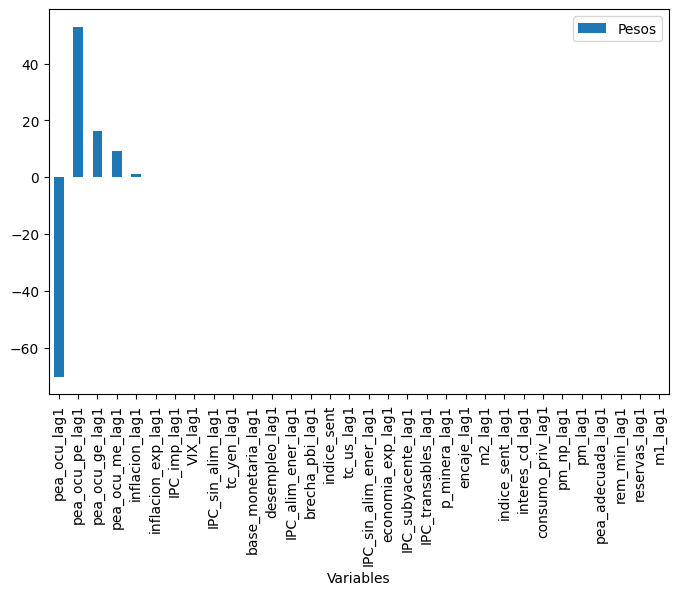

In [66]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lm.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

#### 2.2. Manual selection

In [68]:
# List of features according to economic literature
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled.iloc[:, [1, 6, 12]], y_train) # inflation lag, consumo priv lag, encaje lag
y_pred = lm.predict(X_test_scaled.iloc[:, [1, 6, 12]])

In [69]:
# Metricas de desempeño del modelo
by_hand_corr = pearsonr(y_test, y_pred)[0]
by_hand_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {by_hand_corr:.4f}")
print(f"R^2 on validation: {by_hand_r2:.4f}")

Correlación: 0.9697
R^2 on validation: 0.9260


#### 2.3. P-value selection

In [70]:
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train_scaled)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:              inflacion   R-squared (uncentered):                   0.169
Model:                            OLS   Adj. R-squared (uncentered):             -0.030
Method:                 Least Squares   F-statistic:                             0.8487
Date:                Sun, 02 Jun 2024   Prob (F-statistic):                       0.699
Time:                        16:29:04   Log-Likelihood:                         -414.76
No. Observations:                 166   AIC:                                      893.5
Df Residuals:                     134   BIC:                                      993.1
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [71]:
p_values = res.pvalues
alpha = 0.05

significant_features = []
for i, p_value in enumerate(p_values):
    if p_value < alpha:
        significant_features.append(i)

In [72]:
lm = LinearRegression()
lm.fit(X_train_scaled.loc[:, significant_features], y_train)
y_pred = lm.predict(X_test_scaled.loc[:, significant_features])

In [73]:
# Metricas de desempeño del modelo
pvalue_corr = pearsonr(y_test, y_pred)[0]
pvalue_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {pvalue_corr:.4f}")
print(f"R^2 on validation: {pvalue_r2:.4f}")

Correlación: 0.9699
R^2 on validation: 0.9261


#### 2.4. Lasso selection

In [74]:
# Se evalúan varias valores de lambda
lasso = Lasso(alpha=0.022, max_iter = 5000)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

In [75]:
# Metricas de desempenho del modelo
lasso_r2 = r2_score(y_test, y_pred)
print(f"R^2 on validation: {lasso_r2:.5f}")

R^2 on validation: 0.94153


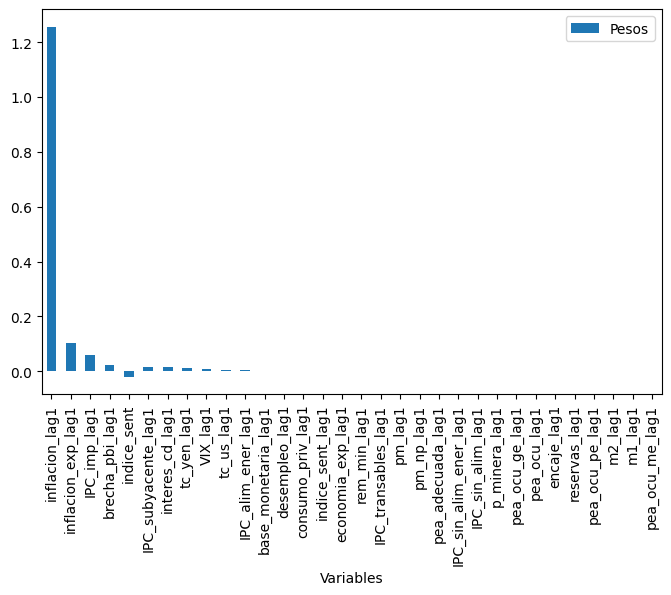

In [76]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lasso.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

In [77]:
lm = LinearRegression()
lm.fit(X_train_scaled.iloc[:, lasso.coef_!=0], y_train)
y_pred = lm.predict(X_test_scaled.loc[:, lasso.coef_!=0])

In [78]:
lasso_corr = pearsonr(y_test, y_pred)[0]
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)

print(f"Correlation: {lasso_corr:.4f}")
print(f"MSE: {lasso_mse:.4f}")
print(f"R^2 on validation: {lasso_r2:.4f}")

Correlation: 0.9668
MSE: 0.3096
R^2 on validation: 0.9337


#### 2.5. Comparación de resultados

In [79]:
# Comparamos los 3 modelos
df_ans = pd.DataFrame({"All features": [all_features_corr, all_features_r2], \
                       "By hand": [by_hand_corr, by_hand_r2], \
                       "P-value": [pvalue_corr, pvalue_r2], \
                       "Lasso": [lasso_corr, lasso_r2]})
df_ans.index = ["Correlacion", "R2"]
df_ans

,All features,By hand,P-value,Lasso
Correlacion,0.966940,0.969694,0.969936,0.966816
R2,0.933365,0.925985,0.926110,0.933683


### 3. Models

In [80]:
X_train_scaled = X_train_scaled.iloc[:, lasso.coef_!=0].copy()
X_test_scaled = X_test_scaled.iloc[:, lasso.coef_!=0].copy()

#### 3.1. VAR

In [81]:
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_pred_var = lm.predict(X_test_scaled)

In [82]:
# Metricas de desempeño del modelo
all_features_corr = pearsonr(y_test, y_pred_var)[0]
all_feature_mae = mean_absolute_error(y_test, y_pred_var)
all_features_mse = mean_squared_error(y_test, y_pred_var)
all_features_r2 = r2_score(y_test, y_pred_var)

print(f"Correlación: {all_features_corr:.4f}")
print(f"MAE en validation: {all_feature_mae:.4f}")
print(f"MSE en validation: {all_features_mse:.4f}")
print(f"R^2 on validation: {all_features_r2:.4f}")

Correlación: 0.9668
MAE en validation: 0.4678
MSE en validation: 0.3096
R^2 on validation: 0.9337


#### 3.2. Ridge regression

In [83]:
# Define rolling window parameters
window_size = 30  # Adjust as needed
step_size = 10

# Initialize lists to store MSE and alpha values
mse_values = []
alpha_values = []

# Iterate over rolling windows
for i in range(0, len(X_train_scaled) - window_size + 1, step_size):
    X_window = X_train_scaled.iloc[i : i + window_size]
    y_window = y_train[i : i + window_size]

    # Fit Ridge regression model
    ridge_model = RidgeCV(alphas=np.arange(0.06, 2, 0.01), cv=5)
    ridge_model.fit(X_window, y_window)

    # Calculate MSE on test data
    y_pred = ridge_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    mse_values.append(mse)
    alpha_values.append(ridge_model.alpha_)

# Choose the optimal alpha
optimal_alpha = alpha_values[np.argmin(mse_values)]
print(f"Optimal alpha: {optimal_alpha:.4f}")


Optimal alpha: 0.0600


In [84]:
# Fit Ridge regression model
ridge = Ridge(alpha=0.0600)
ridge.fit(X_train_scaled, y_train)

y_pred_train = ridge.predict(X_train_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)

In [85]:
# Metricas de desempenho del modelo
ridge_mae_train = mean_absolute_error(y_train, y_pred_train)
ridge_mse_train = mean_squared_error(y_train, y_pred_train)
ridge_r2_train = r2_score(y_train, y_pred_train)

ridge_mae_test = mean_absolute_error(y_test, y_pred_ridge)
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge)
ridge_r2_test = r2_score(y_test, y_pred_ridge)

print(f"MAE en entrenamiento: {ridge_mae_train:.4f}")
print(f"MSE en entrenamiento: {ridge_mse_train:.4f}")
print(f"R^2 on trainning: {ridge_r2_train:.4f}")

print(f"MAE en validation: {ridge_mae_test:.4f}")
print(f"MSE en validation: {ridge_mse_test:.4f}")
print(f"R^2 on validation: {ridge_r2_test:.4f}")

MAE en entrenamiento: 0.2503
MSE en entrenamiento: 0.0997
R^2 on trainning: 0.9461
MAE en validation: 0.4681
MSE en validation: 0.3099
R^2 on validation: 0.9336


#### 3.2 Lasso

In [86]:
# Define rolling window parameters
window_size = 30  # Adjust as needed
step_size = 10

# Initialize lists to store MSE and alpha values
mse_values = []
alpha_values = []

# Iterate over rolling windows
for i in range(0, len(X_train_scaled) - window_size + 1, step_size):
    X_window = X_train_scaled.iloc[i : i + window_size]
    y_window = y_train[i : i + window_size]

    # Fit Ridge regression model
    lasso_model = LassoCV(alphas=np.arange(0.002, 1, 0.001), cv=5)
    lasso_model.fit(X_window, y_window)

    # Calculate MSE on test data
    y_pred = lasso_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    mse_values.append(mse)
    alpha_values.append(lasso_model.alpha_)

# Choose the optimal alpha
optimal_alpha = alpha_values[np.argmin(mse_values)]
print(f"Optimal alpha: {optimal_alpha:.4f}")

Optimal alpha: 0.0090


In [87]:
# Fit Ridge regression model
lasso_reg = Lasso(alpha=0.009)
lasso_reg.fit(X_train_scaled, y_train)

y_pred_train = lasso_reg.predict(X_train_scaled)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

In [88]:
lasso_mae_train = mean_absolute_error(y_train, y_pred_train)
lasso_mse_train = mean_squared_error(y_train, y_pred_train)
lasso_r2_train = r2_score(y_train, y_pred_train)

lasso_mae_test = mean_absolute_error(y_test, y_pred_lasso)
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso)
lasso_r2_test = r2_score(y_test, y_pred_lasso)

print(f"MAE en entrenamiento: {lasso_mae_train:.4f}")
print(f"MSE en entrenamiento: {lasso_mse_train:.4f}")
print(f"R^2 on trainning: {lasso_r2_train:.4f}")

print(f"MAE en validation: {lasso_mae_test:.4f}")
print(f"MSE en validation: {lasso_mse_test:.4f}")
print(f"R^2 on validation: {lasso_r2_test:.4f}")

MAE en entrenamiento: 0.2493
MSE en entrenamiento: 0.1006
R^2 on trainning: 0.9456
MAE en validation: 0.4440
MSE en validation: 0.2854
R^2 on validation: 0.9389


#### 3.3 MRF

In [89]:
df_scaled = pd.DataFrame(scale.fit_transform(df))
df_scaled = df_scaled.set_index(df.index)

In [90]:
data = pd.concat([df.iloc[:, [0]], df_scaled.iloc[:, 1:]], axis=1)

In [91]:
# var dependiente
y_pos = data.columns.get_loc('inflacion')

### Exogenous Variables
S_vars = data.columns[1:].to_numpy()
S_pos = [data.columns.get_loc(s) for s in S_vars]

### Variables Included in Linear Equation
x_vars = data.columns[1:][lasso.coef_!=0].to_numpy()
x_pos = [data.columns.get_loc(x) for x in x_vars]

In [92]:
oos_pos = np.arange(split_point, len(data)) # Row positions of test set/out-of-sample observations

In [101]:
MRF = MacroRandomForest(data = data,
                        y_pos = y_pos,
                        x_pos = x_pos,
                        S_pos = S_pos,
                        B = 100,
                        parallelise = True,
                        n_cores = 3,
                        resampling_opt = 2,
                        oos_pos = oos_pos,
                        trend_push = 4,
                        quantile_rate = 0.3,
                        print_b = True,
                        ridge_lambda = 0.25,
                        fast_rw = True)

In [102]:
MRF_output = MRF._ensemble_loop()

Tree 2 out of 100
Tree 1 out of 100
Tree 3 out of 100
Tree 4 out of 100
Tree 5 out of 100
Tree 6 out of 100
Tree 7 out of 100
Tree 8 out of 100
Tree 9 out of 100
Tree 10 out of 100
Tree 11 out of 100
Tree 12 out of 100
Tree 13 out of 100
Tree 14 out of 100
Tree 15 out of 100
Tree 16 out of 100
Tree 17 out of 100
Tree 18 out of 100
Tree 19 out of 100
Tree 20 out of 100
Tree 21 out of 100
Tree 22 out of 100
Tree 23 out of 100
Tree 24 out of 100
Tree 25 out of 100
Tree 26 out of 100
Tree 27 out of 100
Tree 28 out of 100
Tree 29 out of 100
Tree 30 out of 100
Tree 31 out of 100
Tree 32 out of 100
Tree 33 out of 100
Tree 34 out of 100
Tree 35 out of 100
Tree 36 out of 100
Tree 37 out of 100
Tree 38 out of 100
Tree 39 out of 100
Tree 40 out of 100
Tree 41 out of 100
Tree 42 out of 100
Tree 43 out of 100
Tree 44 out of 100
Tree 45 out of 100
Tree 46 out of 100
Tree 47 out of 100
Tree 48 out of 100
Tree 49 out of 100
Tree 50 out of 100
Tree 51 out of 100
Tree 52 out of 100
Tree 53 out of 100
Tr

In [103]:
forecasts = MRF_output['pred']
betas = MRF_output['betas']

Text(0.5, 1.0, 'OOS predictions of MRF')

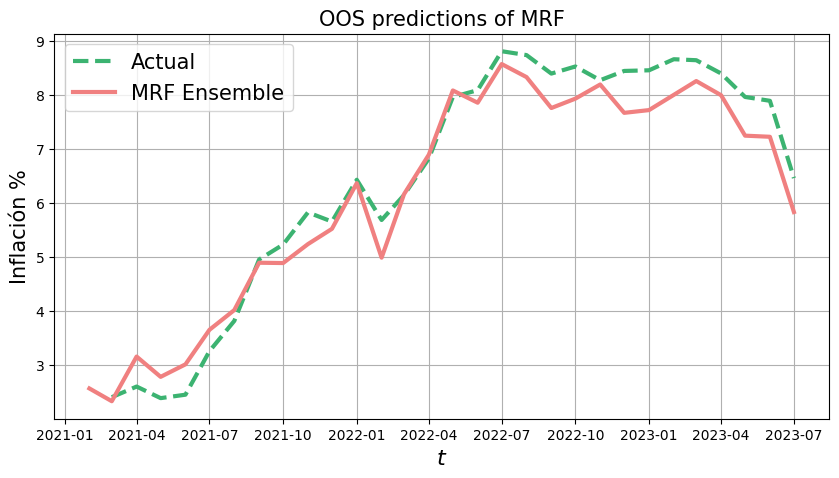

In [104]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (10, 5)

# Plotting actual versus original
ax.plot(data.iloc[split_point:, 0].shift(1), label = 'Actual', linewidth = 3, color ='mediumseagreen', linestyle = '--')
ax.plot(data.iloc[split_point:, 0].index, forecasts, color = 'lightcoral', linewidth = 3, label = "MRF Ensemble")

ax.legend(fontsize = 15)
ax.set_ylabel("Inflación %", fontsize = 15)
ax.grid()
ax.set_xlabel(r"$t$", fontsize = 16)
ax.set_title("OOS predictions of MRF", fontsize = 15)

In [105]:
mrf_mae_test = mean_absolute_error(data.iloc[split_point:, 0], forecasts)
mrf_mse_test = mean_squared_error(data.iloc[split_point:, 0], forecasts)
mrf_r2_test = r2_score(data.iloc[split_point:, 0], forecasts)

print(f"MAE en validation: {mrf_mae_test:.4f}")
print(f"MSE en validation: {mrf_mse_test:.4f}")
print(f"R^2 on validation: {mrf_r2_test:.4f}")

MAE en validation: 0.5206
MSE en validation: 0.3939
R^2 on validation: 0.9156


### 4. Final graph

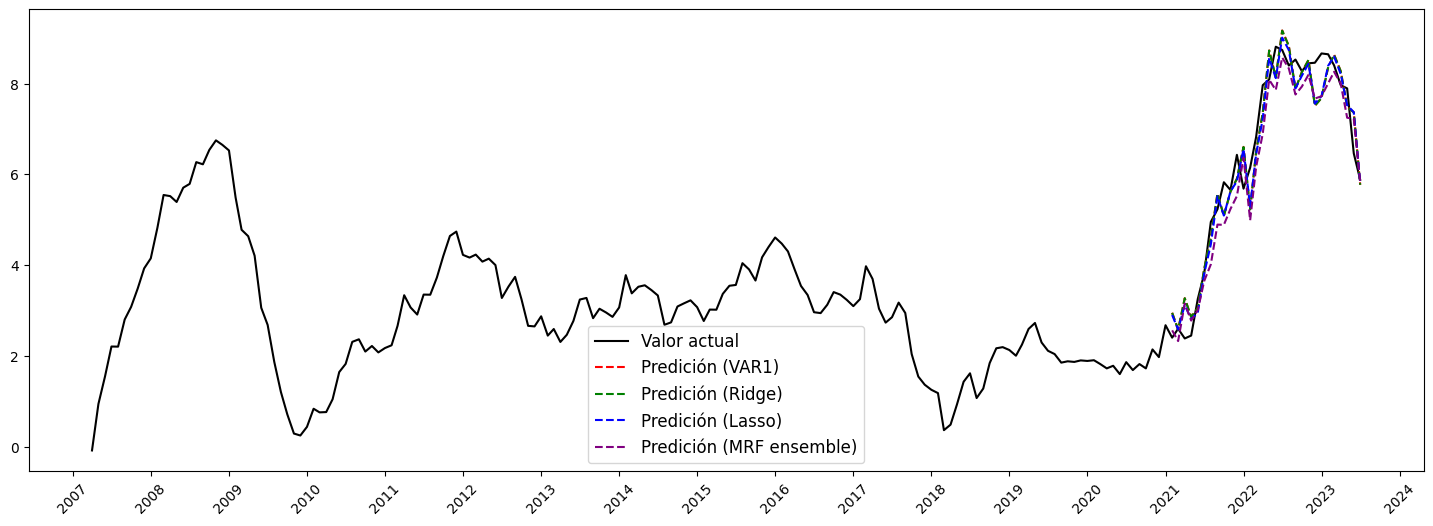

In [106]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df.index, df['inflacion'], label='Valor actual', color='black')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_var, label='Predición (VAR1)', linestyle='--', color='red')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_ridge, label='Predición (Ridge)', linestyle='--', color='green')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_lasso, label='Predición (Lasso)', linestyle='--', color='blue')
ax.plot(df.loc[X_test_scaled.index, :].index, forecasts, label='Predición (MRF ensemble)', linestyle='--', color='purple')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
ax.legend(fontsize=12)
plt.show()